In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load the dataset

In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Update the path to include the Google Drive location
file_path = '/content/drive/MyDrive/final_combined_dataset.pickle'  # Replace 'MyDrive' with your folder if needed

# Now read the pickle file
data = pd.read_pickle(file_path)

Mounted at /content/drive


In [3]:
# Preprocess Data: Convert boards into 6x7x2 representation
def preprocess_data(data):
    boards = []
    labels = []
    for _, item in data.iterrows():
        board = np.array(item['board'])

        # Convert to 6x7x2 format
        if board.shape == (6, 7, 2):
            board_6x7x2 = board
        else:
            board_6x7x2 = np.zeros((6, 7, 2))
            board_6x7x2[:, :, 0] = (board == 1).astype(int)
            board_6x7x2[:, :, 1] = (board == -1).astype(int)

        label = item['recommended_column']
        boards.append(board_6x7x2)
        labels.append(label)

    boards = np.array(boards)
    labels = np.array(labels)

    # One-hot encode labels (7 possible moves)
    labels = tf.keras.utils.to_categorical(labels, num_classes=7)
    return boards, labels

# Get processed data
boards, labels = preprocess_data(data)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(boards, labels, test_size=0.2, random_state=42)

# Reshape Data for Transformer (Flatten the board)
num_samples, n, m, channels = X_train.shape  # (num_samples, 6, 7, 2)
X_train = X_train.reshape(num_samples, n * m, channels)
X_val = X_val.reshape(X_val.shape[0], n * m, channels)

# Debugging Step: Check shape before proceeding
print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, 42, 2)
print(f"y_train shape: {y_train.shape}")  # Expected: (num_samples, 7)

X_train shape: (1003039, 42, 2)
y_train shape: (1003039, 7)


In [4]:
from keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable(package="CustomLayers")
class PositionalIndex(tf.keras.layers.Layer):
    def call(self, x):
        bs = tf.shape(x)[0]  # Extract batch size
        number_of_vectors = tf.shape(x)[1]  # Count the number of vectors (should be m*n)
        indices = tf.range(number_of_vectors)  # Index for each vector
        indices = tf.expand_dims(indices, 0)  # Reshape appropriately
        return tf.tile(indices, [bs, 1])  # Repeat for each batch

@register_keras_serializable(package="CustomLayers")
class ClassTokenIndex(tf.keras.layers.Layer):
    def call(self, x):
        bs = tf.shape(x)[0]  # Extract batch size
        number_of_vectors = 1  # We want just 1 vector for the class token
        indices = tf.range(number_of_vectors)  # Index for the vector
        indices = tf.expand_dims(indices, 0)  # Reshape appropriately
        return tf.tile(indices, [bs, 1])  # Repeat for each batch

@register_keras_serializable(package="CustomLayers")
class ClassTokenSelector(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ClassTokenSelector, self).__init__(**kwargs)

    def call(self, inputs):
        """ Extracts the first token (class token) from the sequence. """
        return inputs[:, 0, :]

    def get_config(self):
        config = super(ClassTokenSelector, self).get_config()
        return config


## Transformer

In [5]:
import tensorflow as tf

def build_ViT(n, m, block_size, hidden_dim, num_layers, num_heads, key_dim, value_dim, mlp_dim, dropout_rate, num_classes):
    inp = tf.keras.layers.Input(shape=(n*m, block_size))
    mid = tf.keras.layers.Dense(hidden_dim)(inp)

    # Positional embeddings
    inp2 = PositionalIndex()(inp)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2)
    mid = tf.keras.layers.Add()([mid, emb])

    # Create and append class token
    tokenInd = ClassTokenIndex()(mid)
    token = tf.keras.layers.Embedding(input_dim=1, output_dim=hidden_dim)(tokenInd)
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    # Transformer layers
    for _ in range(num_layers):
        ln = tf.keras.layers.LayerNormalization()(mid)
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, value_dim=value_dim)(ln, ln, ln)
        add = tf.keras.layers.Add()([mid, mha])
        ln = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim, activation='gelu')(ln)
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        den = tf.keras.layers.Dense(hidden_dim)(den)
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den, add])

    # Use ClassTokenSelector to extract class token
    fl = ClassTokenSelector()(mid)
    ln = tf.keras.layers.LayerNormalization()(fl)
    clas = tf.keras.layers.Dense(num_classes, activation='softmax')(ln)

    mod = tf.keras.models.Model(inp, clas)
    mod.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return mod


In [6]:
# Model hyperparameters
n = 6
m = 7
block_size = 2
hidden_dim = 64
num_layers = 4
num_heads = 4
key_dim = hidden_dim // num_heads  # Good practice for key_dim to be hidden_dim//num_heads
value_dim = key_dim * 2
mlp_dim = hidden_dim
dropout_rate = 0.1
num_classes = 7  # Output classes for classification

# Build the Transformer model
trans = build_ViT(n, m, block_size, hidden_dim, num_layers, num_heads,
                  key_dim, value_dim, mlp_dim, dropout_rate, num_classes)

# Display model summary
trans.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 42, 2)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_index          │ (None, 42)             │              0 │ input_layer[0][0]      │
│ (PositionalIndex)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 42, 64)         │            192 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 42, 64)         │          2,688 │ positional_index[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 42, 64)         │              0 │ dense[0][0],           │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_token_index         │ (None, 1)              │              0 │ add[0][0]              │
│ (ClassTokenIndex)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 64)          │             64 │ class_token_index[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 43, 64)         │              0 │ embedding_1[0][0],     │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 43, 64)         │            128 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 43, 64)         │         24,896 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 43, 64)         │              0 │ concatenate[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 43, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 43, 64)         │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 43, 64)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 43, 64)         │          4,160 │ dropout_1[0][0]        │
├──────────────────────

 Total params: 137,415 (536.78 KB)

 Trainable params: 137,415 (536.78 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
trans.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model to the best state
)

history = trans.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=25,  # Adjust based on performance
                    batch_size=128,
                    callbacks=[early_stopping])  # Tune based on memory and dataset size


Epoch 1/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 131s 14ms/step - accuracy: 0.3295 - loss: 1.6100 - val_accuracy: 0.4065 - val_loss: 1.4582
Epoch 2/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 94s 12ms/step - accuracy: 0.4133 - loss: 1.4332 - val_accuracy: 0.4407 - val_loss: 1.3762
Epoch 3/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 93s 12ms/step - accuracy: 0.4477 - loss: 1.3623 - val_accuracy: 0.4709 - val_loss: 1.3126
Epoch 4/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 93s 12ms/step - accuracy: 0.4710 - loss: 1.3107 - val_accuracy: 0.4901 - val_loss: 1.2676
Epoch 5/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - accuracy: 0.4872 - loss: 1.2732 - val_accuracy: 0.5010 - val_loss: 1.2473
Epoch 6/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step - accuracy: 0.5028 - loss: 1.2397 - val_accuracy: 0.5118 - val_loss: 1.2137
Epoch 7/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step - accuracy: 0.5150 - loss: 1.2103 - val_accuracy: 0.5251 - val_loss: 1.1908
Epoch 8/25
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step - accuracy: 0.5259 

## Test

In [9]:
# plot results
trans.evaluate(X_val, y_val)

7837/7837 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6087 - loss: 0.9950


[0.9994704723358154, 0.6073616147041321]

In [10]:
from tensorflow import keras

trans.save('transformer_model.keras')

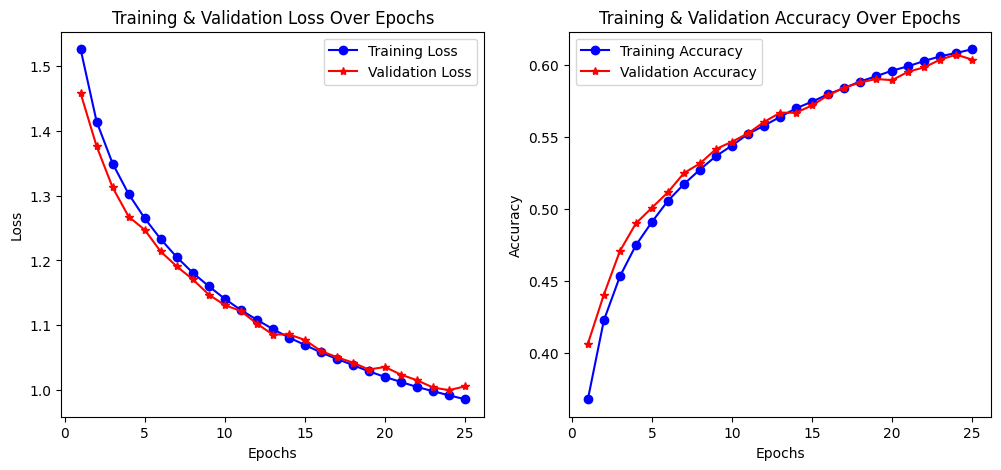

In [11]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # Blue circles
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue circles
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()

# Show plots
plt.show()

In [12]:
from tensorflow.keras.models import load_model

custom_objects = {"PositionalIndex": PositionalIndex, "ClassTokenIndex": ClassTokenIndex}

model = load_model("transformer_model.keras", custom_objects=custom_objects)
